In [3]:
#import Librerie
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # Necessario per la visualizzazione 3D
from kneed import KneeLocator  # Assicura di avere la libreria installata con: pip install kneed

from utils.utils_functions import Utils_functions

In [4]:
X, y = Utils_functions.load_data()

#faccio 4 procedimenti complementari, uno con i dati raw, uno con i dati normalizzati, uno con i dati standardizzati e uno con le componenti principali estratte tramite la pca, durante l'esplorazione del 
#dataset abbiamo notato come il 90% della varianza viene spiegato dalle prime 8 componenti.

#preprocesso i dati
datasets, datasets_names = Utils_functions.process_data(X)

Numero ottimale di cluster (Elbow): 6
Numero reale di cluster: 10
Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.


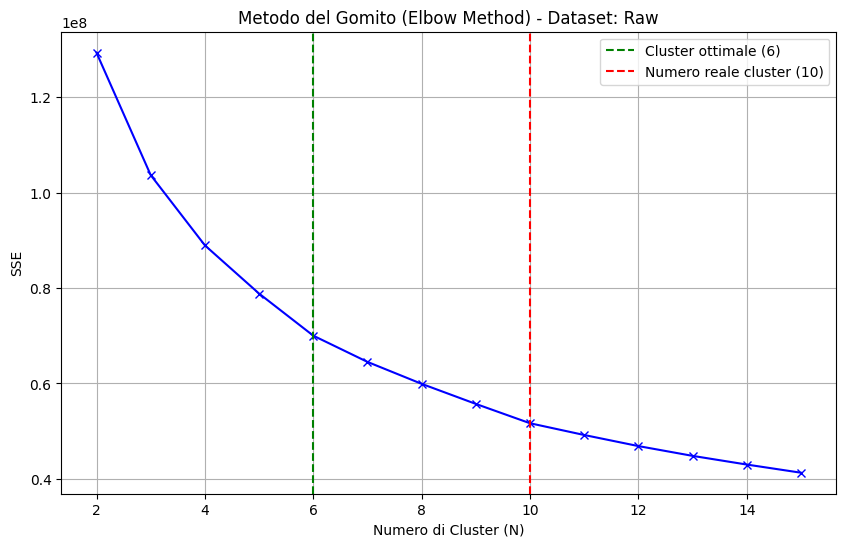

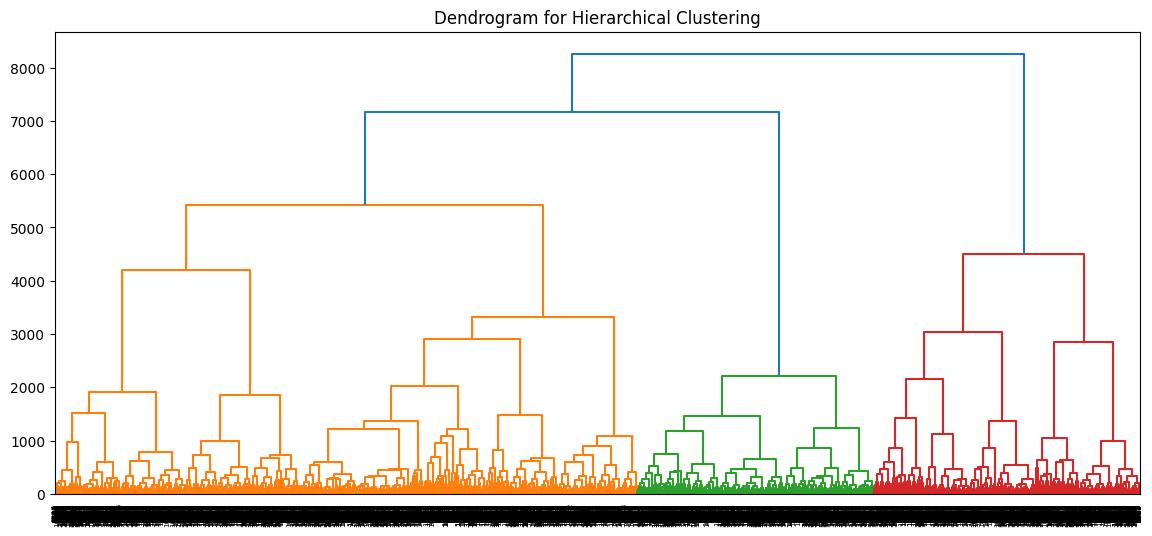

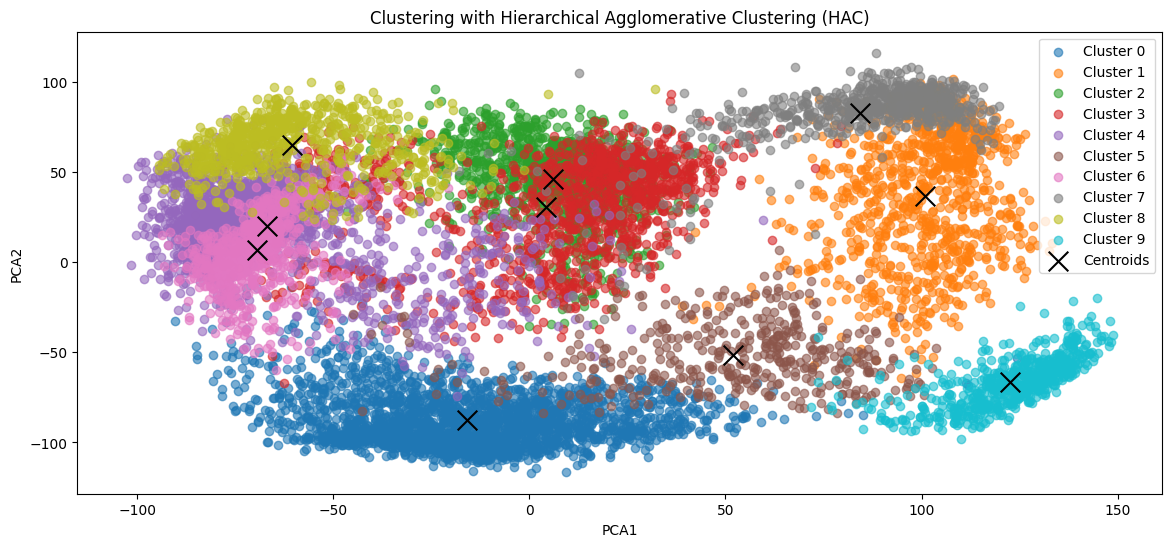

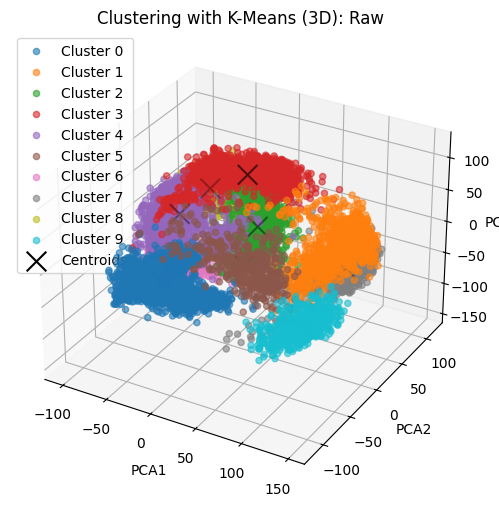

Metriche con Dataset: Raw
ARI: 0.5532013764147102
NMI: 0.7281363125930365
Homogeneity: 0.707537034737052
Completeness: 0.749971016057637
V-Measure: 0.7281363125930364


Numero ottimale di cluster (Elbow): 7
Numero reale di cluster: 10
Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.


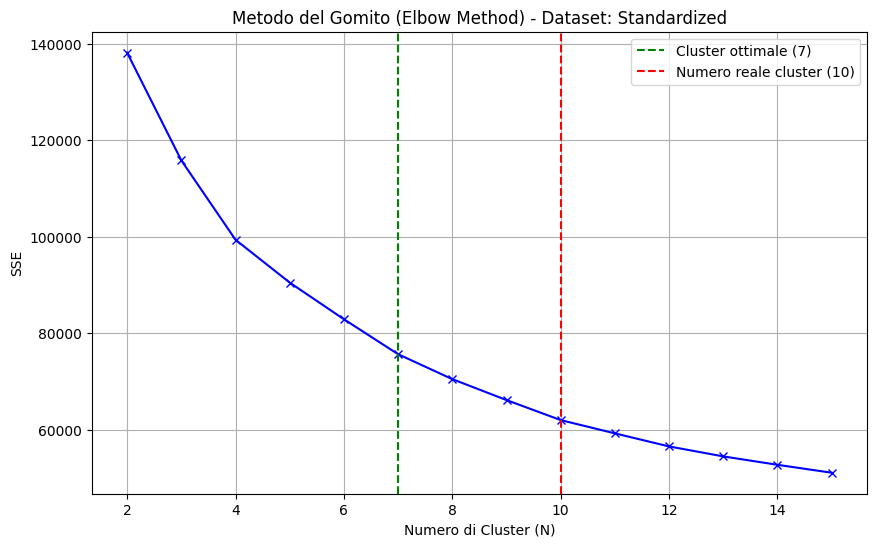

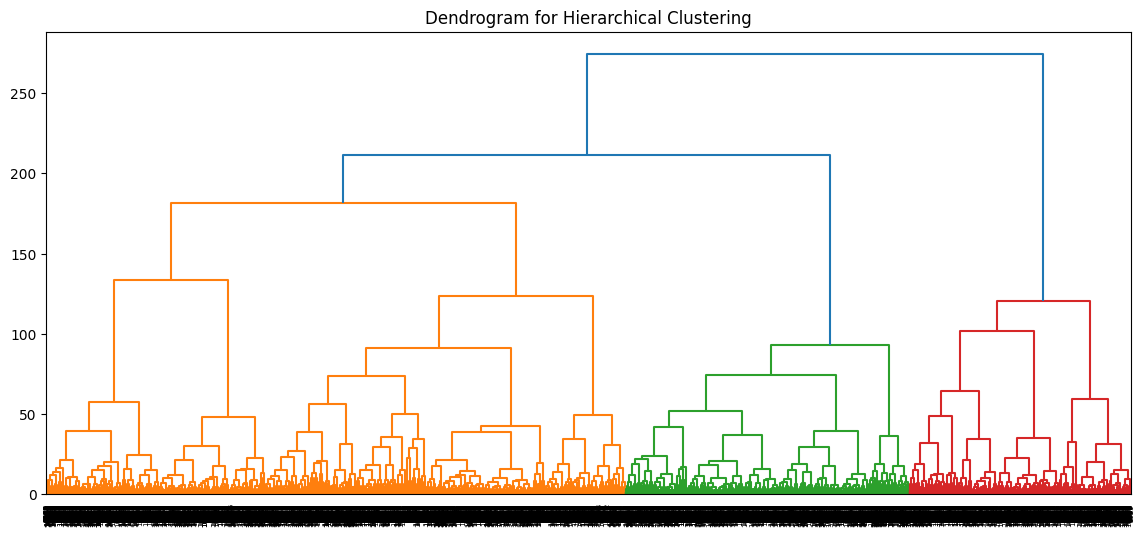

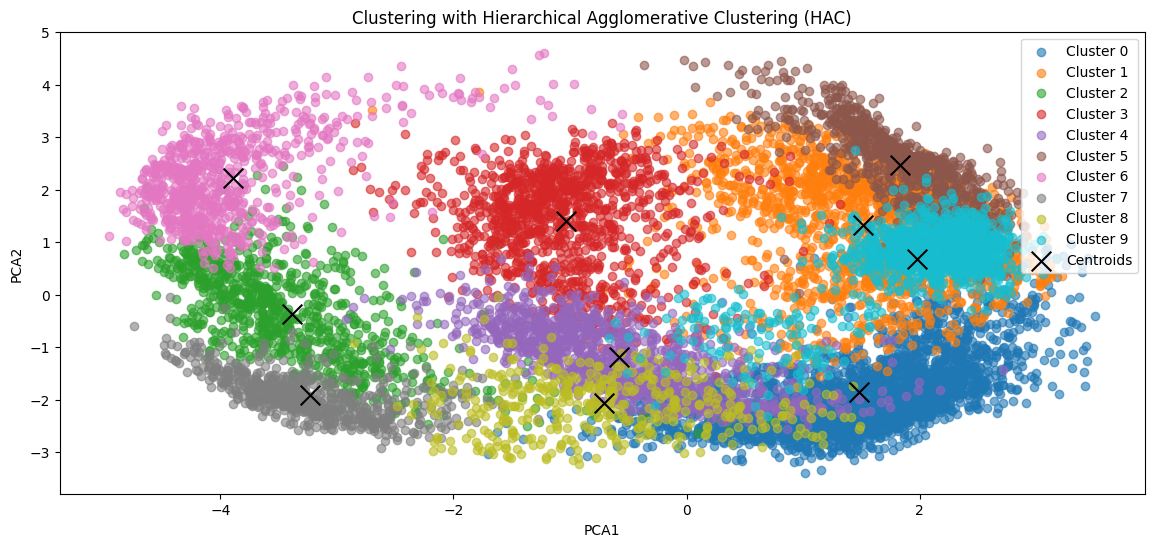

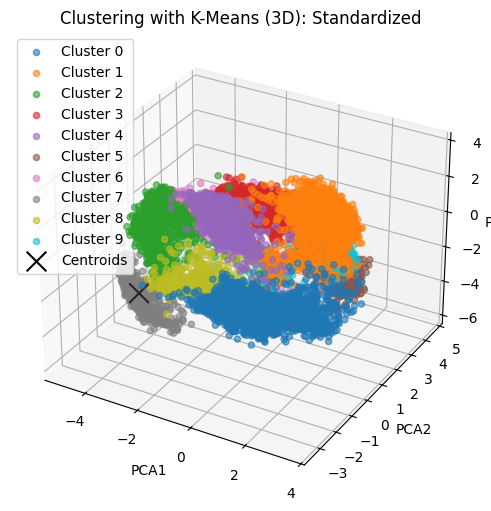

Metriche con Dataset: Standardized
ARI: 0.6103403068918539
NMI: 0.7680806088634107
Homogeneity: 0.7490751614049059
Completeness: 0.7880755701346318
V-Measure: 0.7680806088634106


Numero ottimale di cluster (Elbow): 6
Numero reale di cluster: 10
Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.


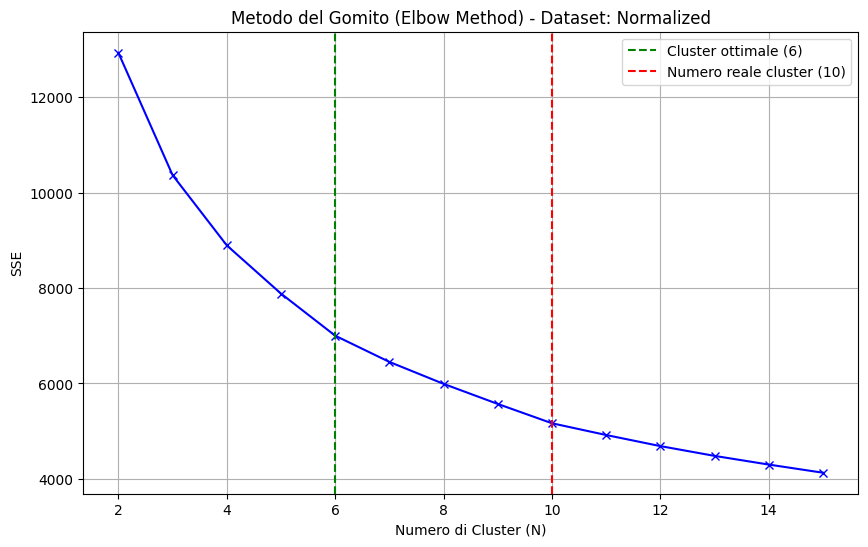

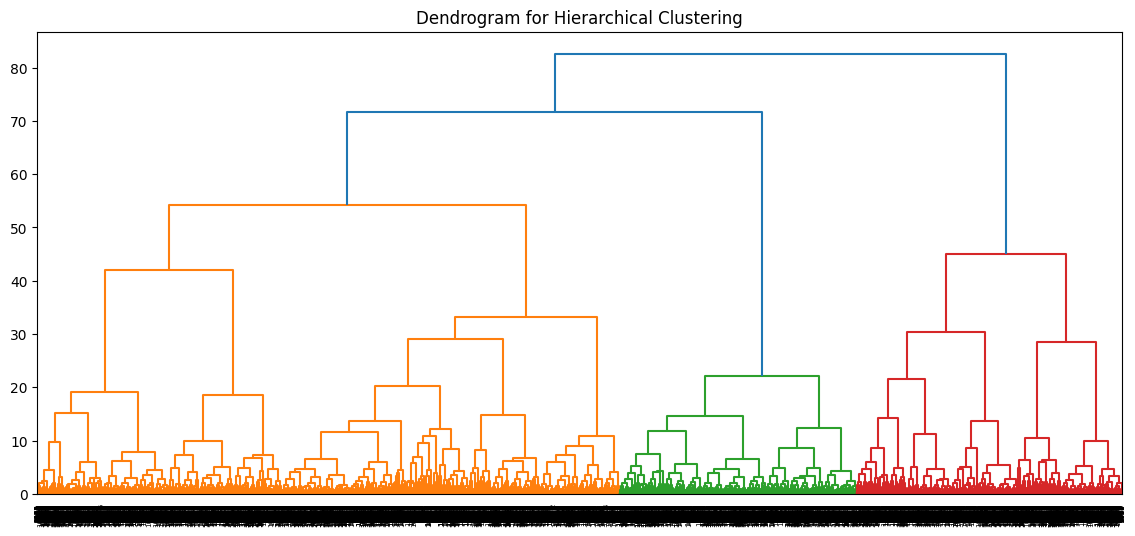

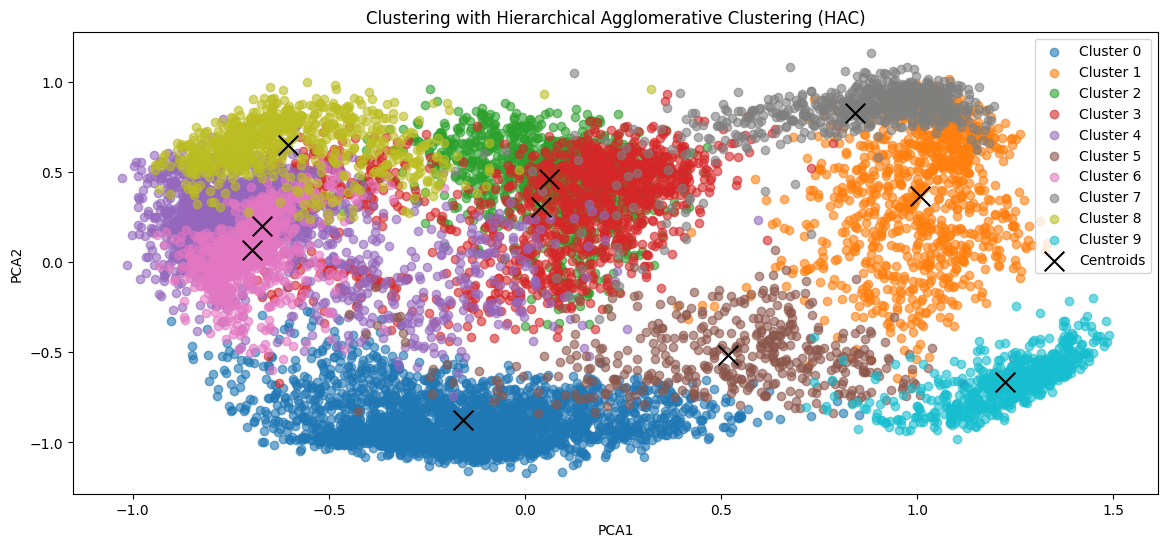

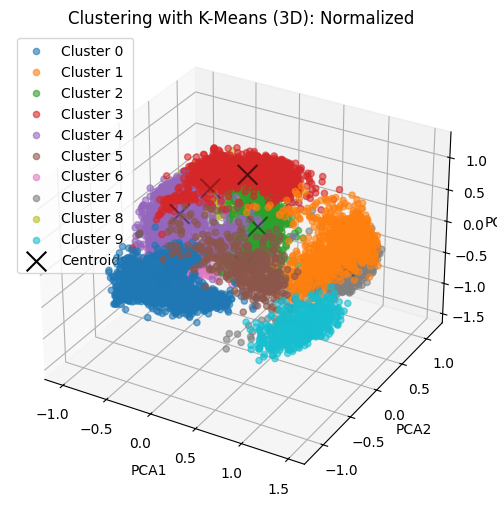

Metriche con Dataset: Normalized
ARI: 0.5532013764147102
NMI: 0.7281363125930365
Homogeneity: 0.707537034737052
Completeness: 0.749971016057637
V-Measure: 0.7281363125930364


Numero ottimale di cluster (Elbow): 7
Numero reale di cluster: 10
Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.


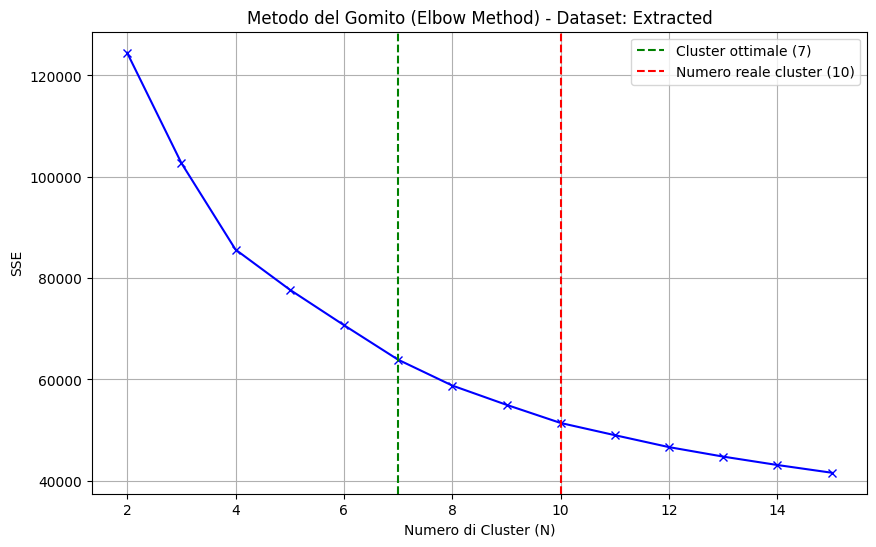

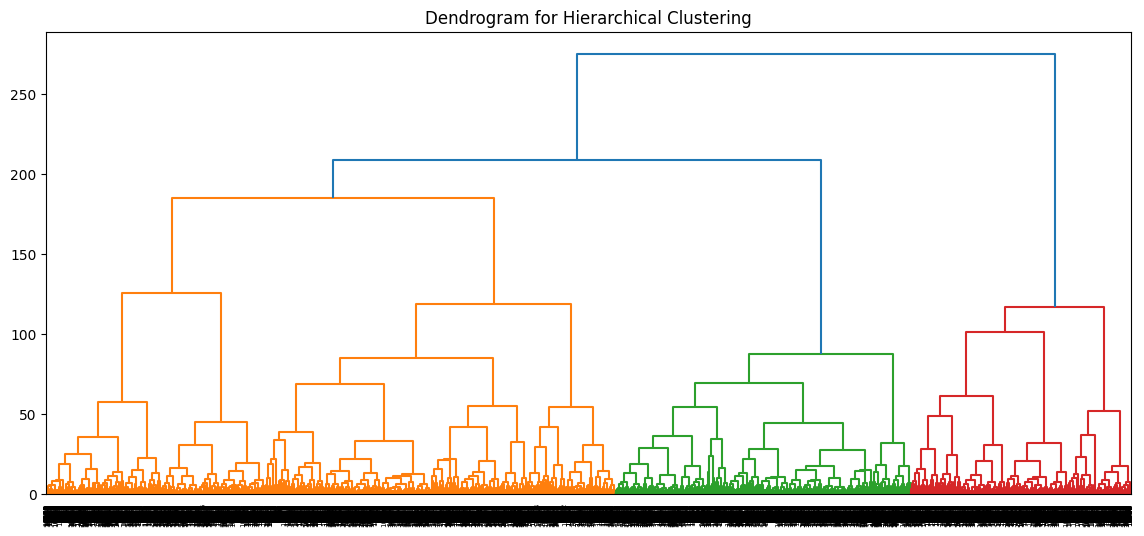

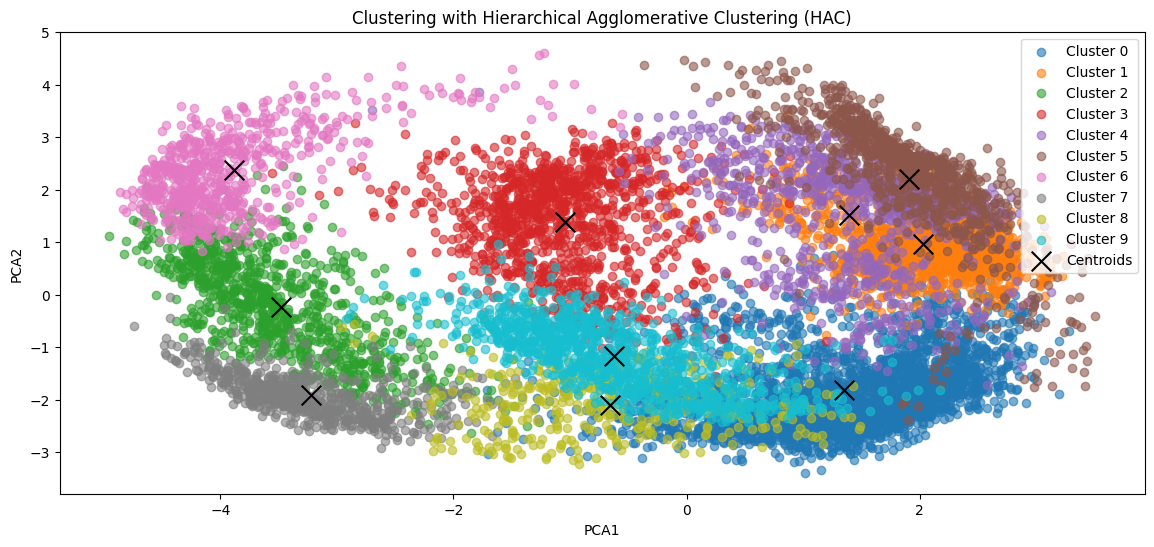

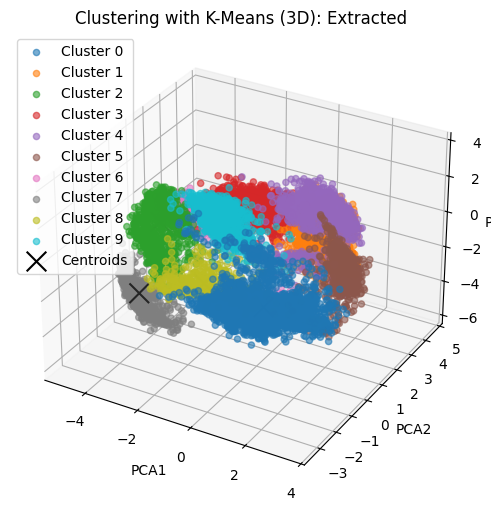

Metriche con Dataset: Extracted
ARI: 0.559668064461233
NMI: 0.7293924481125665
Homogeneity: 0.7089773442473428
Completeness: 0.7510181221815717
V-Measure: 0.7293924481125665




In [5]:
def cluster_sse(X, dataset_name):
    #inizializza una lista vuota da riempire con i valori di sse
    sse_values = []  

    #cicla per tutti i numeri dei cluster
    for n_clusters in range(2, 16):
        hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
        labels = hierarchical_clustering.fit_predict(X)

        #calcola sse
        sse = Utils_functions.compute_SSE(X, labels)
        sse_values.append(sse)

    #troviamo l'elbow point
    kneedle = KneeLocator(range(2, 16), sse_values, curve="convex", direction="decreasing")
    optimal_clusters = kneedle.knee  

    print(f"Numero ottimale di cluster (Elbow): {optimal_clusters}")
    print(f"Numero reale di cluster: 10")
    if optimal_clusters == 10:
        print("Il numero reale di cluster coincide con il numero ottimale secondo la regola dell'elbow.")
    else:
        print("Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.")

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 16), sse_values, 'bx-')
    plt.xlabel('Numero di Cluster (N)')
    plt.ylabel('SSE')
    plt.title(f'Metodo del Gomito (Elbow Method) - Dataset: {dataset_name}')
    plt.axvline(x=optimal_clusters, color='g', linestyle='--', label=f'Cluster ottimale ({optimal_clusters})')
    plt.axvline(x=10, color='r', linestyle='--', label='Numero reale cluster (10)')
    plt.legend()
    plt.grid(True)
    plt.show()

#colonne per PCA
columns = [f"PCA{i}" for i in range(1, 9)]
columns_2d = [f"PCA{i}" for i in range(1, 3)]
columns_3d = columns_2d = [f"PCA{i}" for i in range(1, 4)]

#carico il modello di clustering gerarchico
#linkage: criterio di collegamento, ward minimizza la varianza delle distanze tra i cluster
hierarchical_clustering = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')

#per ogni dataset eseguo il clustering e prendo labels
for i, X in enumerate(datasets):
    
    
    #calcolo la variazione dell'sse in base al numero di cluster
    cluster_sse(X, datasets_names[i])
    
    #eseguo il clustering
    labels = hierarchical_clustering.fit_predict(X)
    
    #linkage per il dendrogramma
    linked = linkage(X, 'ward')
    
    #riduzione dimensionale per i plot
    if (i < 3):
        pca = PCA(n_components=8)
        reduced_data = pca.fit_transform(X)
        #creo un dataframe con i dati ridotti e i cluster
        df_pca = pd.DataFrame(reduced_data, columns=columns)        
    else:
        df_pca = pd.DataFrame(X, columns=columns)
    
    df_pca['Cluster'] = labels

    
    #calcolo i centroidi come media dei punti per ogni cluster
    #per ogni cluster calcolo la media dei punti, prendendo solo i punti del cluster in questione tramite la maschera labels == cluster
    centroids = np.array([df_pca[labels == cluster].mean(axis=0) for cluster in range(10)])
    
    #plotto il dendrogramma
    plt.figure(figsize=(14, 6))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
    plt.title('Dendrogram for Hierarchical Clustering')
    plt.show()
    
    #plot 2D
    plt.figure(figsize=(14, 6))
    for cluster in range(10):
        cluster_data = df_pca[df_pca['Cluster'] == cluster]
        plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], 
                    label=f'Cluster {cluster}', 
                    alpha=0.6)
    
    #plotto i centroidi
    plt.scatter(centroids[:, 0], centroids[:, 1], 
                marker='x', 
                s=200, 
                c='black', 
                label='Centroids')
    
    plt.title('Clustering with Hierarchical Agglomerative Clustering (HAC)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()
    
    #plot 3D
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(111, projection='3d')
    for cluster in range(10):
        cluster_data = df_pca[df_pca['Cluster'] == cluster]
        ax.scatter(cluster_data['PCA1'], cluster_data['PCA2'], cluster_data['PCA3'], label=f'Cluster {cluster}', alpha=0.6)

    #plotto i centroidi
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
                marker='x', 
                s=200, 
                c='black', 
                label='Centroids')
    
    ax.set_title(f'Clustering with K-Means (3D): {datasets_names[i]}')
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.legend()
    plt.show()

    #calcolo i valori di similarità
    ari = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels)
    hom = homogeneity_score(y, labels)
    comp = completeness_score(y, labels)
    vms = v_measure_score(y, labels)

    print(f"Metriche con Dataset: {datasets_names[i]}")
    print(f"ARI: {ari}")
    print(f"NMI: {nmi}")
    print(f"Homogeneity: {hom}")
    print(f"Completeness: {comp}")
    print(f"V-Measure: {vms}")
    print("\n")